## Working with netcdf and defining functions to extract data and plot maps

Some of the functions here were made as I explored the data, are therefore not fully optimized and may not be well-suited to a generalized approach. <br>
If you woud like to use them, favor the functions in the python script "to_import_func_meteo.py"

In [1]:
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import calendar
import seaborn as sns

In [2]:
prcp1930 = nc.Dataset('D:/DaymetCH/ch_prcp_1930-2018_m_ch1903.nc4')
tave1930 = nc.Dataset('D:/DaymetCH/ch_tave_1930-2018_m_ch1903.nc4')
prcp2019 =  nc.Dataset('D:/DaymetCH/ch_prcp_2019_m_ch1903.nc4')
prcp2020 =  nc.Dataset('D:/DaymetCH/ch_prcp_2020_m_ch1903.nc4')
tave2019 =  nc.Dataset('D:/DaymetCH/ch_tave_2019_m_ch1903.nc4')
tave2020 =  nc.Dataset('D:/DaymetCH/ch_tave_2020_m_ch1903.nc4')

Some functions to get data ; beware that some of them rely on comparisons between sheets

In [4]:
# call period example = 'LFI4'.
def get_coordinates(period=str,file=str):
    data = pd.read_excel(file,sheet_name=period) 
    x = data['X']/1000 +600 # coordinates accessed in this way are not centered at x/y=6000/2000 on Bern as they should be, but x/y=1200/1260. The array starts at 4800/740.
    y = data['Y']/1000 +1060 
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    new_year = (year-1929)*12
    new_date = new_year - 12 + month - 1 #index in python starts at 0
    df = new_date,x,y
    return pd.DataFrame(df).astype(int)

In [5]:
dataplot = get_coordinates('LFI2','NFI_data/source data/PLOTDATEN.xlsx')
dataplot

,0,1,2,3,4,5,6,7,8,9,...,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402
DATUMF,777,786,789,788,789,789,788,787,770,788,...,784,784,784,785,784,784,783,783,784,784
X,1288,1289,1320,1317,1323,1326,1307,1326,1279,1314,...,1327,1320,1322,1324,1319,1321,1323,1322,1324,1325
Y,1353,1348,1341,1340,1340,1339,1338,1331,1330,1329,...,1144,1143,1143,1143,1142,1142,1142,1141,1141,1140


In [6]:
def selected_time(time_coords,file):
    d_time = file.variables['time'][time_coords]
    time_unit = file.variables["time"].getncattr('units')
    time_cal = file.variables["time"].getncattr('calendar')
    local_time = nc.num2date(d_time, units=time_unit, calendar=time_cal) 
    return "Selected time : %s" % (local_time)

In [10]:
selected_time(dataplot[0][0],prcp1930) #first slicing : column for first plot. second slicing : first element, time

'Selected time : 1994-10-31 00:00:00'

### Extracting meteorological data for specific time/plots

These functions output the sum of precipitations / average temperature between two data collection campaigns (LFI1, LFI2, LFI3, LFI4) and precipitation / average temperature of the month it was collected.<br>
This will not work properly if you selected LFI1 in previous functions above.

In [6]:
def get_prcp_plot(line,data):
    prcp1930.set_auto_maskandscale(False)   
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    old_date = old_year - 12 + month - 1
    date = dataplot[line][0]
    x = dataplot[line][1]
    y = dataplot[line][2]
    current = prcp1930['prcp'][date,y,x]
    old_to_current = prcp1930['prcp'][old_date[line]:date,x,y]
    return round(sum(old_to_current),4),current


def get_tave_plot(line,data):
    tave1930.set_auto_maskandscale(False)     
    month = data['DATUMF'].dt.month
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    old_date = old_year - 12 + month - 1
    date = dataplot[line][0]
    y = dataplot[line][1]
    x = dataplot[line][2]
    current = tave1930['tave'][date,y,x]
    old_to_current = tave1930['tave'][old_date[line]:date,x,y]
    return round(np.mean(old_to_current),4),current


In [6]:
tave1930.set_auto_mask(False)
prcp1930.set_auto_mask(False)
previous = pd.read_excel('NFI_data/source data/PLOTDATEN.xlsx',sheet_name='LFI1') #use previous sheet 

In [22]:
selected_index = 620
prcp_v1, prcp_v2 = get_prcp_plot(selected_index,previous)
tave_v1, tave_v2 = get_tave_plot(selected_index,previous)
print(f"Precipitation in this period in plot index {selected_index} is {str(round(prcp_v1,4))} cm, precipitation during month of collection is {str(round(prcp_v2,4))} cm") 
print(f"Temperature average in this period in plot index {selected_index} is {str(round(tave_v1,4))} °C, temperature average during month of collection is {str(round(tave_v2,4))} °C") 

Precipitation in this period in plot index 620 is 1560.524 cm, precipitation during month of collection is 9.4794 cm
Temperature average in this period in plot index 620 is 9.0425 °C, temperature average during month of collection is 12.2135 °C


Creating files to merge them later with NFI data

In [59]:
prcp_append = []
for i in range(len(dataplot.columns)):
    prcp_append.append(get_prcp_plot(i,previous))

In [60]:
prcp_xls = pd.DataFrame(prcp_append,columns=['PRCP_SUM','PRCP'])
prcp_xls.to_excel('prcp_lf1-2.xlsx')

In [61]:
tave_append = []
for i in range(len(dataplot.columns)):
    tave_append.append(get_tave_plot(i,previous))

In [62]:
tave_xls = pd.DataFrame(tave_append,columns=['TAVE_AVG','TAVE'])
tave_xls.to_excel('tave_lf1-2.xlsx')

Similar to the 2 functions above, returns the sum of precipitations / average temperature between two data collection campaigns (LFI1, LFI2, LFI3, LFI4) and precipitation / average temperature, but here only for the months of forest growth (april to september included).

In [13]:
def select_weather_growth_months(line,data,file,kind):
    file.set_auto_maskandscale(False)
    year = data['DATUMF'].dt.year
    old_year = (year-1929)*12
    date = dataplot[line][0]
    x = dataplot[line][1]
    y = dataplot[line][2]
    interval_y = int(((date - old_year)/12)[0])
    interval_1 = []
    interval_2 = []
    prcp_result = []
    tave_result = []
    for i in range(interval_y):
        interval_1.append(old_year[line]+(12*i+3))
        interval_2.append(old_year[line]+(12*i+8))
        prcp_result.append(np.sum(file[kind][interval_1[i]:interval_2[i],x,y]))
        tave_result.append(np.mean(file[kind][interval_1[i]:interval_2[i],x,y]))
    if kind == 'prcp':
        return sum(prcp_result)
    elif kind == 'tave':
        return np.mean(tave_result)
    
#example : select_weather_growth_months(0,previous,prcp1930,'prcp')

In [14]:
kind_1 = 'tave'
kind_2 = 'prcp'
selected_index = 0

wg_tave = round(select_weather_growth_months(selected_index,previous,tave1930,kind_1),4)
wg_prcp = round(select_weather_growth_months(selected_index,previous,prcp1930,kind_2),4)

print(f"Precipitation in this period during months of growth (April to September included) in plot index {selected_index} is {str(wg_prcp)} cm") 
print(f"Temperature average in this period during months of growth (April to September included) in plot index {selected_index} is {str(wg_tave)} °C") 

Precipitation in this period during months of growth (April to September included) in plot index 0 is 349.8349 cm
Temperature average in this period during months of growth (April to September included) in plot index 0 is 14.5928 °C


In [5]:
dataplot = get_coordinates('LFI4','NFI_data/source data/PLOTDATEN.xlsx')
previous = pd.read_excel('NFI_data/source data/PLOTDATEN.xlsx',sheet_name='LFI3')

Appending data for growth months to files

In [ ]:
prcp_growth_append = []
for i in range(len(dataplot.columns)):
    prcp_growth_append.append(select_weather_growth_months(i,previous,prcp1930,'prcp'))

In [87]:
df_prcp = pd.read_excel("prcp_lf1-2.xlsx").drop('Unnamed: 0',axis=1)
df_prcp['PRCP_GROWTH'] = prcp_growth_append
df_prcp.to_excel('prcp_lf1-2.xlsx')

In [ ]:
tave_growth_append = []
for i in range(len(dataplot.columns)):
    tave_growth_append.append(select_weather_growth_months(i,previous,tave1930,'tave'))

In [90]:
df_tave = pd.read_excel("tave_lf1-2.xlsx").drop('Unnamed: 0',axis=1)
df_tave['TAVE_GROWTH'] = tave_growth_append
df_tave.to_excel('tave_lf1-2.xlsx')

### Plotting maps

A map for a given month, either precipitation in cm or temperature average in °C

In [6]:
def plot_image(meteo,file,kind):
    if kind == 'prcp':
        palette = 'viridis'
        label = 'Precipitations in cm'
    elif kind == 'tave':
        palette = 'magma'
        label = 'Temperature average in C°'
    d_time = file.variables['time'][meteo]
    time_unit = file.variables["time"].getncattr('units')
    month = nc.num2date(d_time,units=time_unit).month
    year = nc.num2date(d_time,units=time_unit).year
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(file[kind][meteo],origin='lower',cmap=palette)
    #plt.gcf().set_facecolor("white")
    plt.colorbar(orientation='horizontal',fraction=0.025,label=label) 
    plt.title(f"{label} for month {month} of year {year}")
    plt.show()

In [7]:
tave1930.set_auto_maskandscale(True)
prcp1930.set_auto_maskandscale(True)
# this has to be reactivated to plot maps

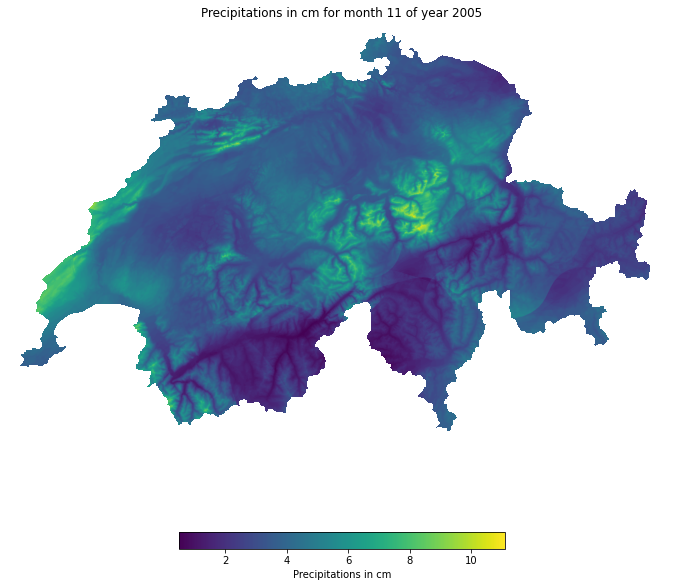

In [117]:
plot_image(dataplot[0][0],prcp1930,'prcp')

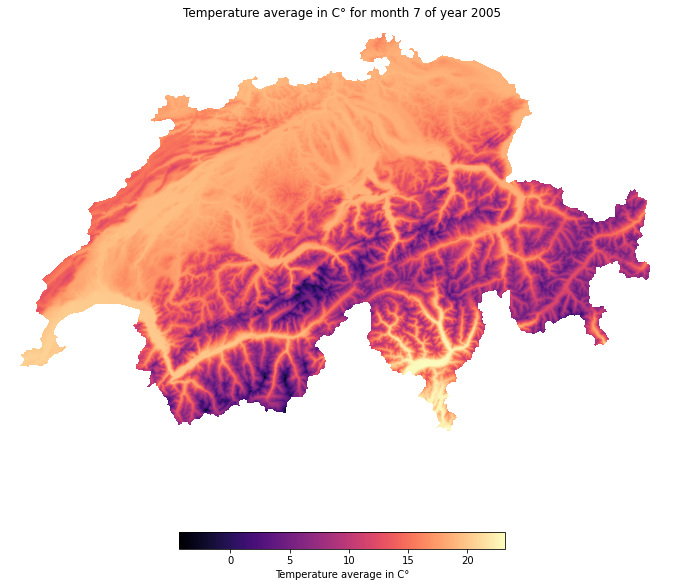

In [124]:
plot_image(906,tave1930,'tave')

Plotting image for a given interval

In [8]:
def plot_image_interval(meteo_start,meteo_end,file,kind):
    if kind == 'prcp':
        palette = 'viridis'
        label = 'Precipitations (in cm)'
    elif kind == 'tave':
        palette = 'magma'
        label = 'Average Surface Air Temperature (in C°)'
    d_time_s = file.variables['time'][meteo_start]
    time_unit = file.variables["time"].getncattr('units')
    month_start = nc.num2date(d_time_s,units=time_unit).month
    year_start = nc.num2date(d_time_s,units=time_unit).year
    d_time_e = file.variables['time'][meteo_end]
    month_end = nc.num2date(d_time_e,units=time_unit).month
    year_end = nc.num2date(d_time_e,units=time_unit).year
    meteo = file[kind][meteo_start]
    for i in range(meteo_start+1,meteo_end+1):
        meteo += file[kind][i]
    if kind == 'tave':
        meteo /= (meteo_end-meteo_start)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(meteo,origin='lower',cmap=palette)
    plt.gcf().set_facecolor("white")
    plt.colorbar(orientation='horizontal',fraction=0.025,label=label) 
    plt.title(f"{label}, from {calendar.month_name[month_start]} of {year_start} to {calendar.month_name[month_end]} of {year_end}")
    plt.show()

LFI1 = March 1983 to October 1985 : 638,669<br>
LFI2 = May 1993 to May 1996 : 760,796<br>
LFI3 = April 2004 to November 2006 : 891,922<br>
LFI4 = November 2009 to November 2017 : 958,1054<br>

LFI1-2

In [19]:
print(f"Time interval between {selected_time(638,tave1930)} and {selected_time(796,tave1930)}")

Time interval between Selected time : 1983-03-31 00:00:00 and Selected time : 1996-05-31 00:00:00


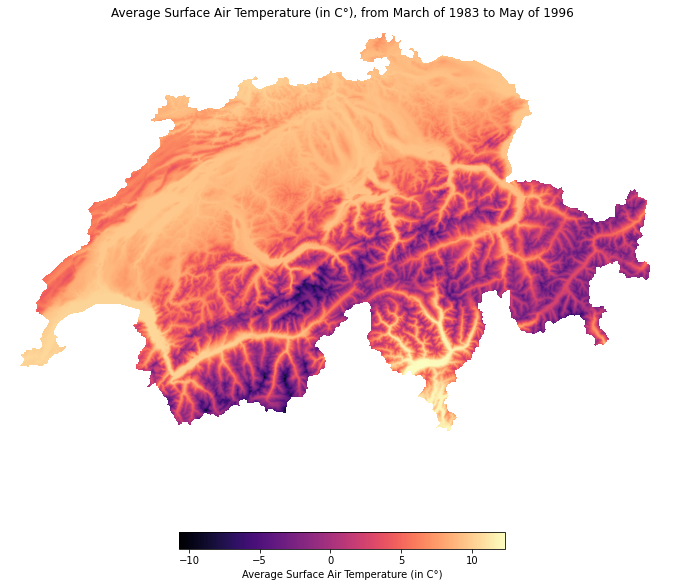

In [11]:
plot_image_interval(638,796,tave1930,'tave')

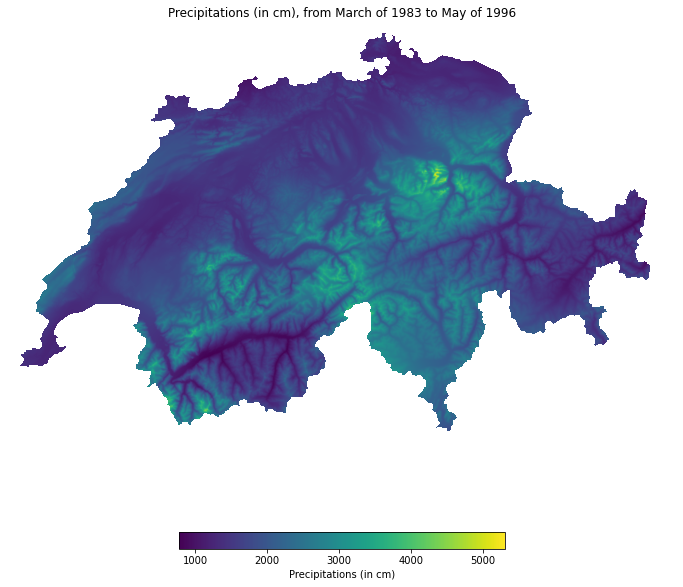

In [12]:
plot_image_interval(638,796,prcp1930,'prcp')

LFI2-3

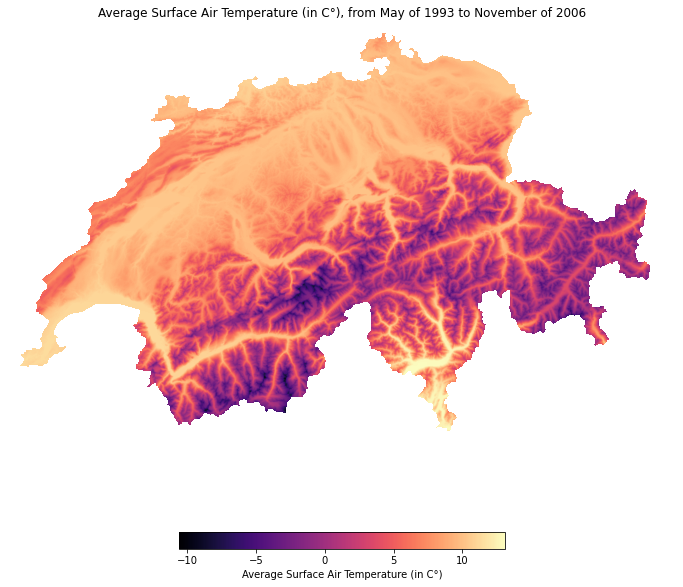

In [15]:
plot_image_interval(760,922,tave1930,'tave')

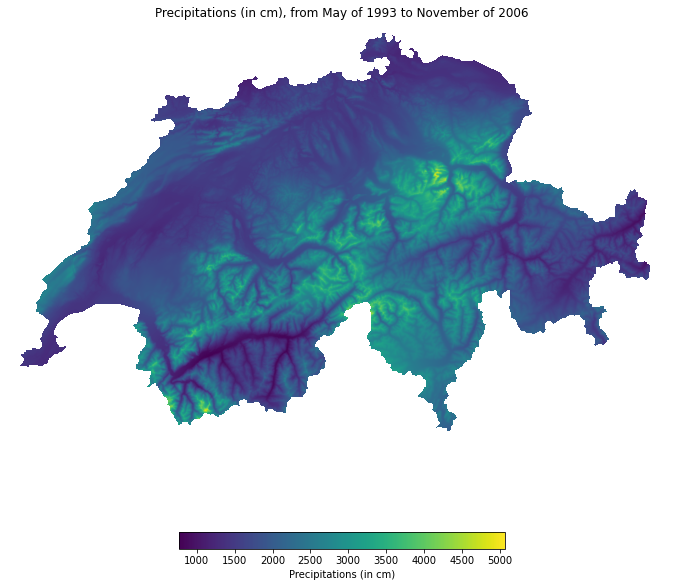

In [16]:
plot_image_interval(760,922,prcp1930,'prcp')

LFI3-4

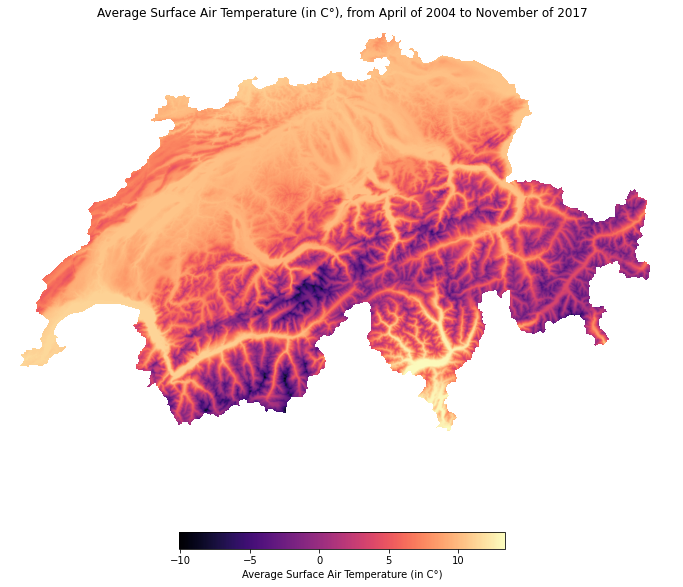

In [20]:
plot_image_interval(891,1054,tave1930,'tave')

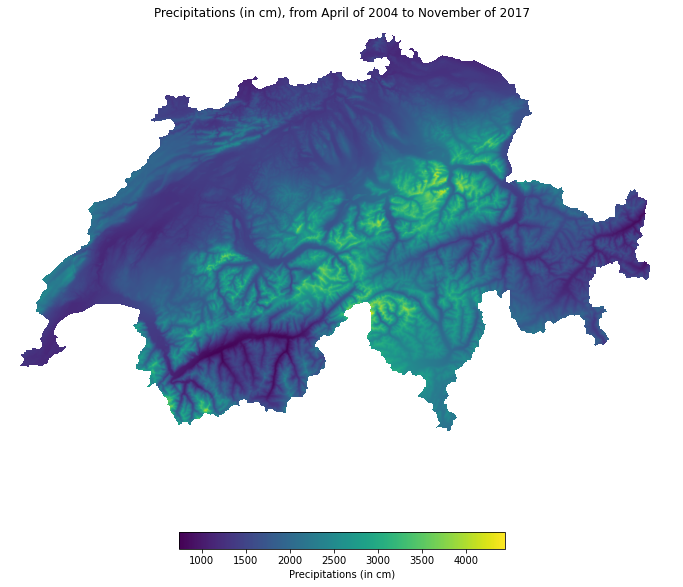

In [21]:
plot_image_interval(891,1054,prcp1930,'prcp')